### Your project is to create forecasting model that will predict the ICE BofA BBB US Corporate Index Effective Yield one day forward(will code 30days but focus on the first). You will also back test this model on data that will not contain the recent economic COVID-19 crisis. 

#### Using a neural Network you will need to determine is is this model have adequate predictive capibilities and would there be room for improvment in the model and if is it necessary.

In [110]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Importing Data from
 -https://fred.stlouisfed.org/series/BAMLC0A4CBBBEY

In [94]:
data = pd.read_csv("resources/ICSBOFABBB.csv", parse_dates = True, index_col="DATE")

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6166 entries, 1996-12-31 to 2020-04-29
Data columns (total 1 columns):
BAMLC0A4CBBBEY    6166 non-null object
dtypes: object(1)
memory usage: 96.3+ KB


## Cleaning Data
- Because the data contain "." and all values are listed as Strings we will need to remove and convert the values to float values

In [8]:
bbb = pd.to_numeric(data[data["BAMLC0A4CBBBEY"] != "."]["BAMLC0A4CBBBEY"])

In [9]:
bbb = pd.DataFrame(bbb)

In [10]:
bbb.columns = ["bbb"]

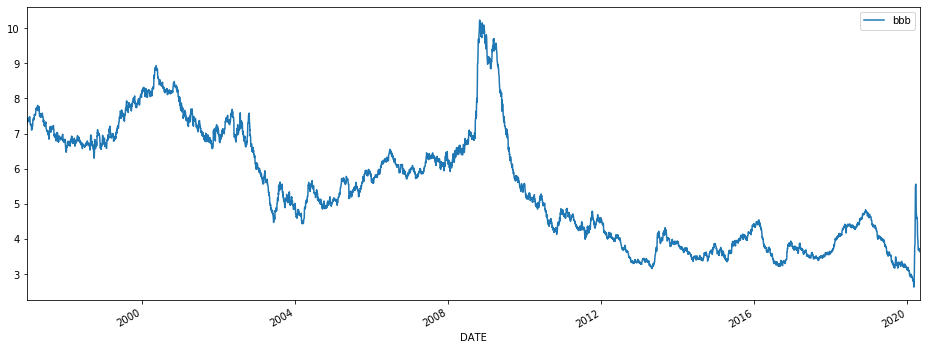

In [11]:
bbb.plot(figsize = (16,6))

In [12]:
bbb.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6087 entries, 1996-12-31 to 2020-04-29
Data columns (total 1 columns):
bbb    6087 non-null float64
dtypes: float64(1)
memory usage: 95.1 KB


### Time series has 6087 days 24 years (considering 253 trading days)

### Sample size 
- Will consider 3 years of data to test
- 759 trading days (253 days)
- 3 years seems to be a resonable amout of data to consider for the movement of the BBB Index

In [13]:
test_sample = 759

In [14]:
test_index = len(bbb) - test_sample

In [15]:
test_index

5328

### Training /Testing
- Splitting the data to training and testing set

In [16]:
train = bbb.iloc[:test_index]

In [17]:
test = bbb[test_index:]

In [18]:
train.shape

(5328, 1)

In [19]:
test.shape

(759, 1)

## Scaling data 
- scaling to allow our model to consider outlyers 
- this will assist in increasing accuracy and finding patters

In [95]:
from sklearn.preprocessing import MinMaxScaler

In [21]:
scalar = MinMaxScaler()

In [22]:
train_scaled = scalar.fit_transform(train)

In [23]:
test_scaled = scalar.transform(test)

### Time series Batch Generator
- will use 30 trading as our length to allow to have the model work to predict 30 days
- We must consider that the mode days out while forecating will cause lower accuracy
- This is why we will only focus on one day our in our forecast

In [24]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [25]:
length = 30

In [26]:
gen = TimeseriesGenerator(train_scaled, train_scaled, length= length,batch_size=1)

### Validation generator
- Will allow our model have data to compare training to

In [27]:
valid_Gen = TimeseriesGenerator(test_scaled,test_scaled, length= length, batch_size=1)

### Early Stopping
- Early stopping will allow us to stretch our epochs while preventing overtraining on the model

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
stop = EarlyStopping(monitor="val_loss", mode="min", patience=2)

## model creation
- We will load a previous model before fitting again
- See below

In [30]:
n_features = 1

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [45]:
##model = Sequential()
#model.add(LSTM(units = 100, activation = "relu", input_shape = (length,n_features)))
#model.add(Dense(units = 1))
#model.compile(optimizer = "adam", loss = "mse")

## fitting model 

In [32]:
#model.fit_generator(generator=gen, validation_data=valid_Gen, epochs=20, callbacks=[stop])

## Model Performance
- Loaded form our previous model

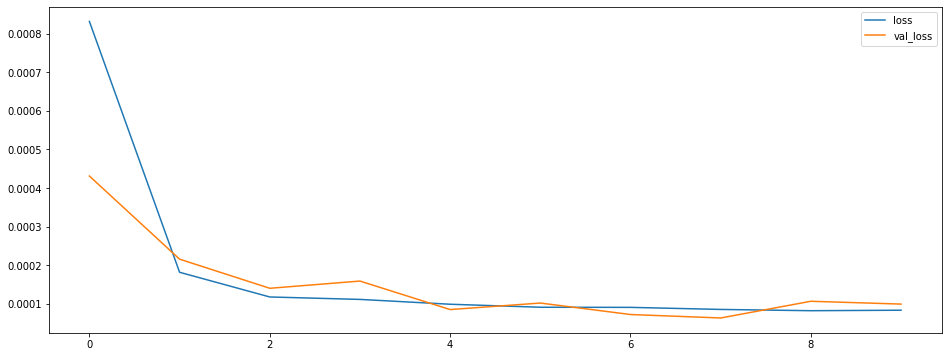

In [51]:
pd.DataFrame(model.history.history).plot(figsize = (16,6))

### Model Predictions on length (30 days)
- Before forecasting we will use the model to predict what the BBB index would be for those 30 days
- Again we will only focus on the first dat for best accuracy

In [50]:
test_predictions = []
batch = train_scaled[-length:]
current_batch = batch.reshape((1,length,n_features))
for i in range(len(test)):
    current_prediciton = model.predict(current_batch)[0]
    test_predictions.append(current_prediciton)
    current_batch = np.append(current_batch[:,1:,:], [[current_prediciton]], axis = 1)

In [53]:
true_predicitons = scalar.inverse_transform(test_predictions)

In [56]:
test["predictions"] = true_predicitons

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Model Accuracy
- Looks like the model is predicting 3.55 
- True value for 2017-06-01 was 3.54
- model is pretty accurate for the first day 
- Below we will look at a foreast

In [60]:
test

,bbb,predictions
DATE,,
2017-06-01,3.54,3.554680
2017-06-02,3.50,3.579742
2017-06-05,3.51,3.605697
2017-06-06,3.48,3.632273
2017-06-07,3.51,3.659288
...,...,...
2020-04-23,3.69,12.294054
2020-04-24,3.68,12.294054
2020-04-27,3.72,12.294054


## Everything moving forward
- Everyting after the first day will be considered "NOISE"
- Will not consider

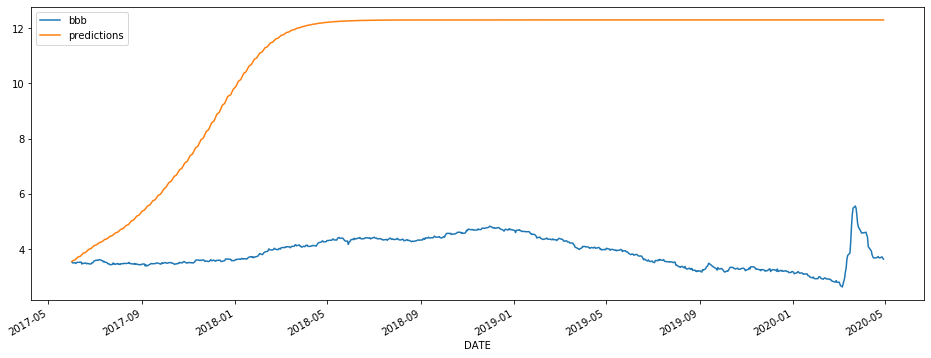

In [59]:
test.plot(figsize = (16,6))

### Model FIrst day prediciton are very accurate. We will use this to forecast into the future
- Again, forecasting 30 daya but will focus on the first
- last day in our data wa 2020-4-29 
- we will forecast 30days after that

In [97]:
bbb.tail()

,bbb
DATE,
2020-04-23,3.69
2020-04-24,3.68
2020-04-27,3.72
2020-04-28,3.67
2020-04-29,3.64


In [98]:
all_scaler = MinMaxScaler()

In [99]:
bb_scaled = all_scaler.fit_transform(bbb)

In [100]:
forecast = []
period = length
batch = bb_scaled[-length:]
curr_batch = batch.reshape((1,length,n_features))
for i in range(period):
    pred = model.predict(curr_batch)[0]
    forecast.append(pred)
    curr_batch = np.append(curr_batch[:,1:,:], [[pred]], axis = 1)

## Inverse Scaling 
- Our forecast was on scaled data 
- Since our model was trained on scaled data we will inverse 
- This will give us the true values

In [101]:
true_forecast = all_scaler.inverse_transform(forecast)

In [103]:
bbb.tail()[-1:]

,bbb
DATE,
2020-04-29,3.64


## Forecast Time Series
- Will need to generate 30 days after the end of our data

In [104]:
time_index = pd.date_range(start= "2020-04-30", periods= period, freq="B")

In [105]:
time_index

DatetimeIndex(['2020-04-30', '2020-05-01', '2020-05-04', '2020-05-05',
               '2020-05-06', '2020-05-07', '2020-05-08', '2020-05-11',
               '2020-05-12', '2020-05-13', '2020-05-14', '2020-05-15',
               '2020-05-18', '2020-05-19', '2020-05-20', '2020-05-21',
               '2020-05-22', '2020-05-25', '2020-05-26', '2020-05-27',
               '2020-05-28', '2020-05-29', '2020-06-01', '2020-06-02',
               '2020-06-03', '2020-06-04', '2020-06-05', '2020-06-08',
               '2020-06-09', '2020-06-10'],
              dtype='datetime64[ns]', freq='B')

In [107]:
forecast_df = pd.DataFrame(true_forecast, index= time_index, columns=["forecast"])

## First two days forecast
- We will focus on the first day oir of the 30 but displaying 2
- prediction for 2020-4-30
- 3.67

In [109]:
forecast_df.head(2)

,forecast
2020-04-30,3.671385
2020-05-01,3.695478


(737060.0, 737551.0)

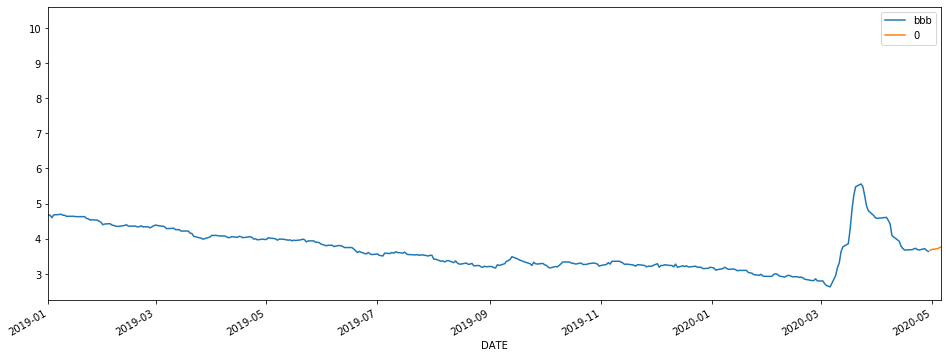

In [86]:
ax  = bbb.plot(figsize = (16,6))
forecast_df.plot(ax = ax)
plt.xlim("2019-1-1","2020-05-6")

## Backtesting with Model
- Will remove 2020 out of the data set 
- True value from FREDS for 2020-4-30 was 3.42 so our model was off 
- This could be due to the economic crisis so lets back test before 2020
- This will allow us to see how our model is predicting without a econimoc Crisis

In [2]:
from tensorflow.keras.models import load_model

In [3]:
model = load_model("BBB_model.h5")

### Data before 2020
- This will allow us to see if our model accuracy will improve in non crisis phases of the economy

In [37]:
bbb_pre_2020 = bbb.loc["1996-12-31": "2019-1-1"] 

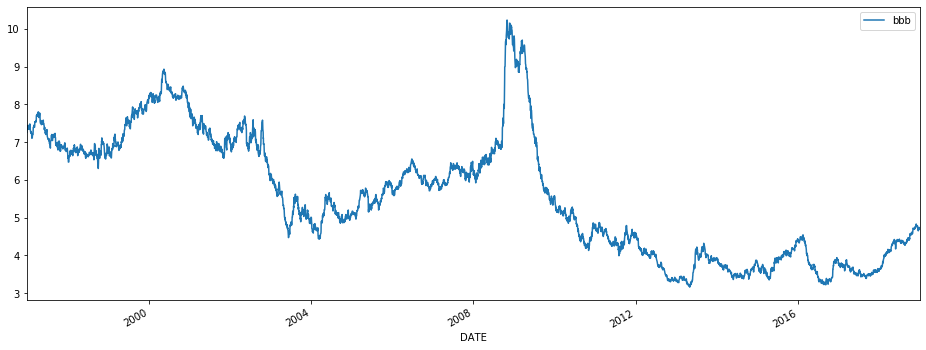

In [40]:
bbb_pre_2020.plot(figsize = (16,6));

### Forecasting - using the past data
- Not including 2020
- will use our new data series
- data range "1996-12-31" - "2019-1-1"
- last day will be 2018-12-31

In [62]:
bbb_pre_2020.tail()[-1:]

,bbb
DATE,
2018-12-31,4.69


In [63]:
test_scalar = MinMaxScaler()

In [64]:
pre_2020_scaled = test_scalar.fit_transform(bbb_pre_2020)

In [65]:
forecast = []
time_period = length
ba = pre_2020_scaled[-length:]
bat = ba.reshape((1,length,n_features))
for i in range(time_period):
    pre = model.predict(bat)[0]
    forecast.append(pre)
    bat = np.append(bat[:,1:,:], [[pre]], axis = 1)

In [67]:
true_for = test_scalar.inverse_transform(forecast)

In [89]:
time_index = pd.date_range(start="2019-01-02", periods=time_period, freq="B")

### Time Series for Forecast - pre 2020
- start 2019-1-2, end 2019-2-12

In [90]:
time_index

DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15', '2019-01-16', '2019-01-17',
               '2019-01-18', '2019-01-21', '2019-01-22', '2019-01-23',
               '2019-01-24', '2019-01-25', '2019-01-28', '2019-01-29',
               '2019-01-30', '2019-01-31', '2019-02-01', '2019-02-04',
               '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08',
               '2019-02-11', '2019-02-12'],
              dtype='datetime64[ns]', freq='B')

In [91]:
for_df = pd.DataFrame(true_for, index=time_index, columns=["forecast"])

## Model on backtesting
- Model predicts 4.71 for 2019-01-02
- Actual was 4.67
- .85% failure rate
- We can deem this as a pretty good model in regular circumstances

In [92]:
for_df.head(1)

,forecast
2019-01-02,4.719072


In [93]:
bbb.loc["2019-01-02":"2019-02-12"].head(1)

,bbb
DATE,
2019-01-02,4.67


### Over all the model performs pretty well in normal circumstances. Because the Economic is more unpredictable during these time we need to consider that the model will not perform as well in these circumstances. 

### To improve the model we may need to train on th entire data set and a few other approached. To answer the question, is it worth it?, maybe not. That being said because an economic crisis can cause highy unpredictablity in any market. The model would stand strong when the economy is back to "normal"